# Assignment 3
# Part I: Windows-based stereo $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\longleftarrow 70\;pts$

In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2grey

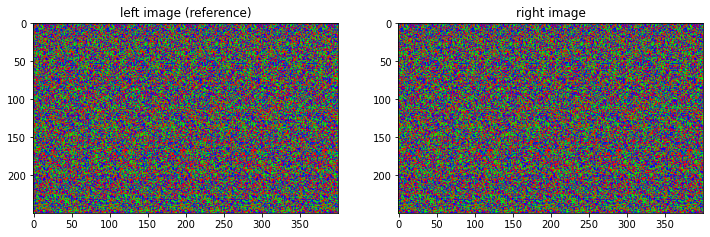

In [3]:
# you should use this random dot stereo pair for code developing/testing in Probelms 1-5
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

### Problem 1: compute and visualize (as an image) an array of "squared differences" between RGB pixel values in the left and the right images. Treat each RGB pixel value as 3-vector and interprete "squared difference" as squared L2 norm of the difference between the corresponding vectors. 
###  HINT (important here and later): <font color=red> convert R, G, B values to floats to avoid severe "overflow" bugs </font> while adding small-range types (one-byte for $char$) or subtracting unsigned types. Note that $imshow$ function can display (as an image) any 2D array of floats.

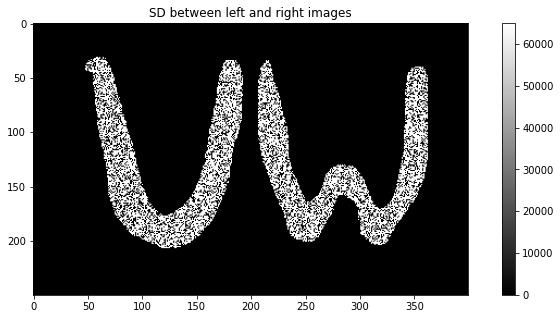

In [4]:
im_left.astype(np.float)
im_right.astype(np.float)
SD = np.square(np.linalg.norm(im_left - im_right, axis=-1))

fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

### Problem 2: write function for computing squared differences between RGB pixel values in the reference (left) image and the "shifted" right image for ALL shifts/disparities $\Delta$ in the range $\Delta\in [d_{min},d_{max}]$. You should think about the correct direction of the shift. The output should be array $SD$ such that $SD[i]$ is an image of Squared Differences for shift $\Delta = d_{min} + i$ for any $i\in [0,d_{max}-d_{min}]$. 

In [5]:
def SD_array(imageL, imageR, d_minimum, d_maximum):
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    for i in range(d_maximum - d_minimum + 1):
        imageR_shifted = np.roll(imageR, i + d_minimum, axis=1)
        diff = imageL.astype(float) - imageR_shifted.astype(float)
        SD[i,:,:] = np.square(np.linalg.norm(diff, axis=-1))
    return SD

### Use $\text{SD_array}$ function to compute SD images for the random dot stereo pair. Visualize such squared difference images for $\Delta=d_{min}$, $\Delta = d_{mid}\approx\frac{d_{min}+d_{max}}{2}$, and $\Delta=d_{max}$. Note that the first image should be identical to the one in Problem 1. (fully implemented)

(250, 400, 4)
(250, 400, 4)
(3, 250, 400)


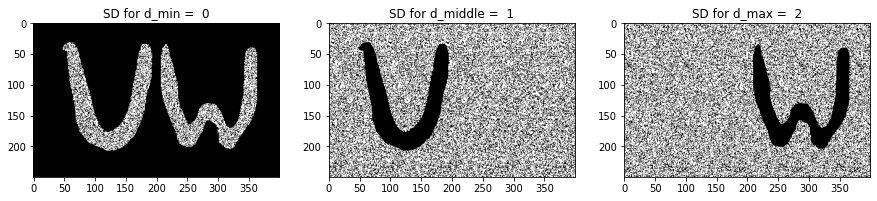

In [6]:
SD = SD_array(im_left, im_right, d_min, d_max)    
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

### Problem 3: write function to compute an "integral image" for any given "scalar" image

In [7]:
# Function integral_image can be applied to any scalar 2D array/image. 
# This function should return a double/float64 (precision) array/image of the same size.
# NOTE: it is safer to explicitly specify double/float64 precision for integral images since 
# later we will be adding/subtracting ("differenting") their values in nearby pixels .

def integral_image(img):
    result = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i == 0 and j == 0:
                result[i, j] = img[i, j]
            elif j == 0:
                result[i, j] = img[i, j] + result[i-1, j]
            elif i == 0:
                result[i, j] = img[i, j] + result[i, j-1]
            else:
                result[i, j] = img[i, j] + result[i, j-1] + result[i-1, j] - result[i-1, j-1] 
    return result.astype(np.float64)

### apply $\text{intergal_image}$ function to the "squared differences" (SD) for each disparity (fully implemented)

(3, 250, 400) (3, 250, 400)


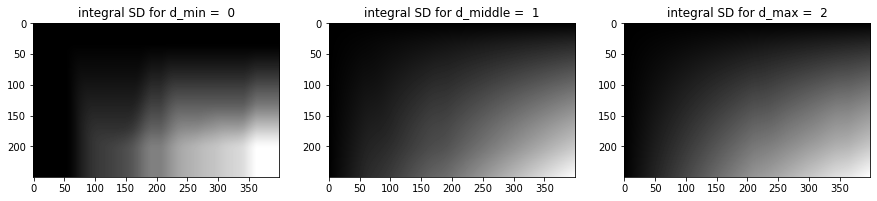

In [8]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])
        
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Problem 4: write function that sums the elements of the input image within fixed-size windows around image pixels. Note that this function should work for any (odd or even) values of parameter $\text{window_width}\in\{1,2,3,4,5,...\}$ according to the windows illustration below: <img src="images\windows.png">

In [9]:
# function windSum can be applied to any scalar 2D array/image. It should return an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image should be of the same size/type and have its margins (around half-window width) filled with INFTY.
# NOTE: you should use function integral_image implemented earlier.
# HINT: you should use standard np.roll function to avoid double or triple for loops.
INFTY = np.inf

def windSum(img, window_width):
    half_ww = math.floor(window_width/2)
    
    br = integral_image(img)
    
    tl = np.roll(br, window_width, axis=0)
    tl = np.roll(tl, window_width, axis=1)
    tl[0:window_width, :] = np.zeros(tl[0:window_width, :].shape)
    tl[:, 0:window_width] = np.zeros(tl[:, 0:window_width].shape)
    
    bl = np.roll(br, window_width, axis=0)
    bl[:, 0:window_width] = np.zeros(bl[:, 0:window_width].shape)

    tr = np.roll(br, window_width, axis=1)
    tr[0:window_width, :] = np.zeros(tr[0:window_width, :].shape)
    
    result = br - bl - tr + tl
    result = np.roll(result, -math.floor(window_width/2), axis=0)
    result = np.roll(result, -math.floor(window_width/2), axis=1)
    
    result[0:half_ww+window_width%2, :] = np.full(result[0:half_ww+window_width%2, :].shape, INFTY)
    result[:, 0:half_ww+window_width%2] = np.full(result[:, 0:half_ww+window_width%2].shape, INFTY)

    if half_ww != 0:
        result[-(half_ww):, :] = np.full(result[-(half_ww):, :].shape, INFTY)
        result[:, -(half_ww):] = np.full(result[:, -(half_ww):].shape, INFTY)
    
    return result

### Compute SSD images for windows of different widths and for different disparities by applying $\text{windSum}$ function to the "squared differences" SD. Note that the results for windows of width 1 (the first row of the figure below) should look identical (except for the narrow "margin") to the results in Problem 2. (fully implemented)

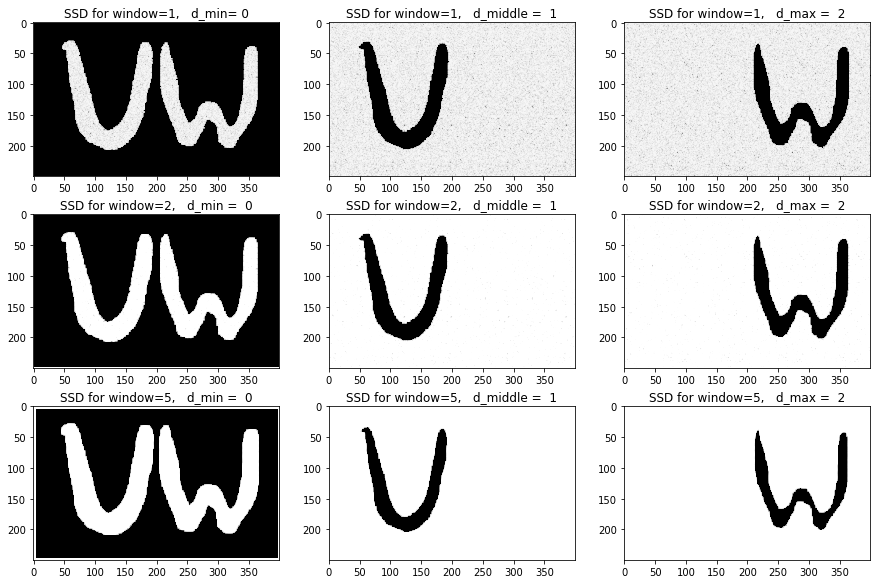

In [10]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

### Problem 5: write code for function computing "disparity map" from SSD arrays (as above) for each disparity in the range specified by integers $d_{min}$, $d_{max}$. It should return a disparity map (image). At each pixel, disparity map image should have disparity value corresponding to the minimum SSD at this pixel. For pixels at the margins, the disparity map should be set to zero. HINT: margin pixels are characterized by $INFTY$ values of $SSD$.

In [11]:
# You should use functions np.where (pointwise "if, then, else" operation) and np.minimum (pointwise "minimum" operation)
# These functions will help to avoid double loops for traversing the pixels.
# WARNING: there will be a deducton for double-loops traversing pixels, but single loop to traverse disparities is OK.

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    dMap = d_minimum + np.argmin(SSD_array, axis=0)
    dMap = np.where(dMap==INFTY, 0, dMap)
    return dMap

### Compute and show disparity map (fully implemented)

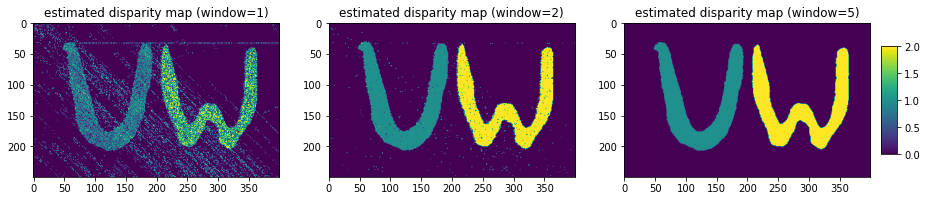

In [12]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

### Problem 6: test your code on a real stereo pair with ground truth (Tsukuba)

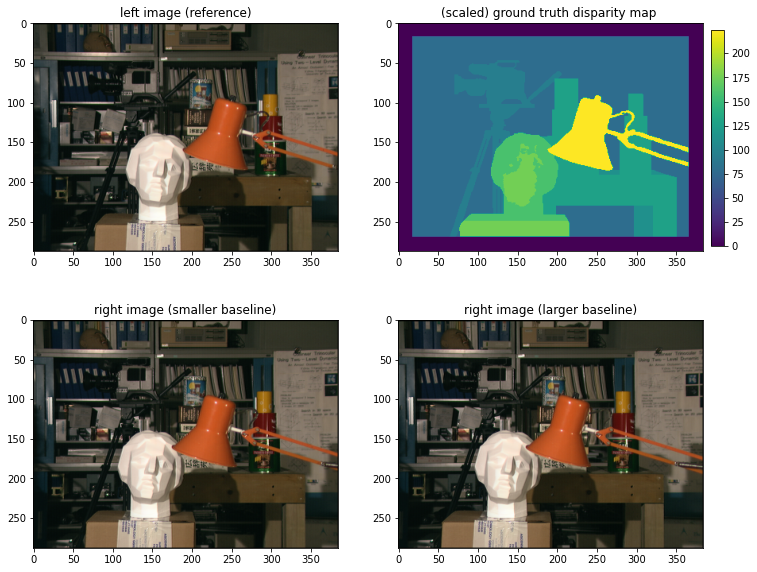

In [13]:
# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

### Note that the integer-valued ground truth image above represents scaled disparity values for the pixels in the reference (left) mage. The scale w.r.t. the smaller baseline right image ($\text{im_right}$) is 16 and for the larger baseline image ($\text{im_right2}$) is 8. Below, you should use the smaller-baseline right image ($\text{im_right}$). 

### Problem 6a: Using ground truth disparity map, estimate the range of disparity values between pixels in the left image ($\text{im_left}$) and the right image ($\text{im_right}$) .

In [47]:
# Solution: use standard functions to find min and max values in the ground truth disparity map. 
# You should ignore 0-valued margin!

d_min = 0 # change me
d_max = 15 # change me

### Compute squared differences using $\text{SD_array}$ function and visualize the results using logarithmic scale. Note that linear scale would make it hard to see smaller squared differences since there are many very large ones. (fully implemented)

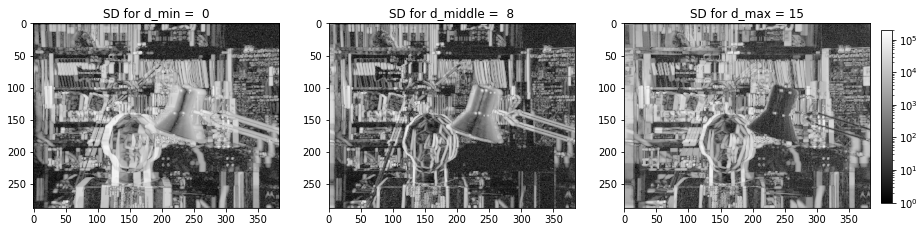

In [48]:
SD = SD_array(im_left, im_right, d_min, d_max)    
    
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Problem 6b: Explain the differences you observe above:

Answer: When d is small, the background of the SD is dark, indicating that the intensity difference is small. When d is large, the objects at the front becomes darker, which means that these objects have larger shifts in the left and right image. (eg. The background changes from dark to light from left to right. The lamp changes from white to black.)

### Problem 6c: Write function $\text{Dmap_Windows}$ that returns disparith map from a given stereo pair (left and right image), specified disparity range, and window size. Your implementation should combine functions implemented and debugged earlier ($\text{SD_array}$, $\text{windSum}$, and $\text{SSDtoDmap}$).

In [16]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    
    for Delta in range(1 + d_maximum - d_minimum):
        SSD[Delta] = windSum(SD[Delta], window_width)
    
    return SSDtoDmap(SSD, d_minimum, d_maximum)

### Compute and show disparity maps for Tsukuba using small and large windows. (fully implemented)

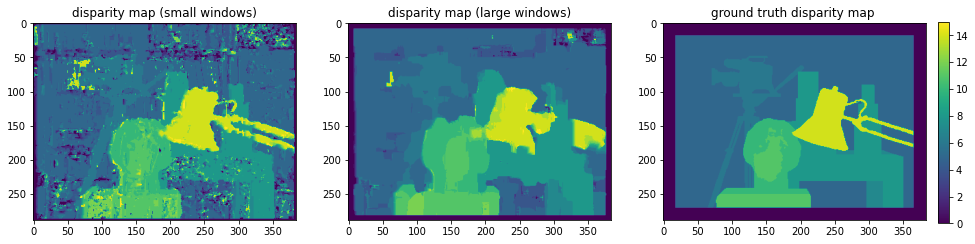

In [17]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

# Part II: Scan-line stereo   $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\longleftarrow 30\;pts$

### Problem 7(a):  Program $Viterbi$ approach discussed in class and apply it to Tsukuba example. For the photo-consistency term  of the loss function (objective function) you can use previously implemented $\text{SD_array}$ $$D_p(d) = |I_p-I_{p+d}|^2 \;\;\;\;\;\longleftarrow\;\;\;\; \text{SD_array}[d][p] $$ that for every pixel $p$ defines the cost for every possible disparity value $d\in\{d_{min},...,d_{max}\}$. The regularization term should be as discussed in class $$V_{pq}(d_p,d_q) = w|d_p-d_q|$$ where you can select some good value for parameter $w$ empirically (start from $w\approx 0$).  Discuss the differences with the window-based stereo results above.

### NOTE: You should implement $Viterbi$ optimization yourself - it was fully covered in class. Organize your code (e.g. add cells, introduce functions, write comments, ect) as part of your mark will depend on clarity. The main iteration of the forward pass in Viterbi ($m^2$-complexity operation for each pair of neighboring pixels on a scan-line) can be implemented as a separate function. You can avoid double for-loops using functions like  𝑛𝑝.𝑤ℎ𝑒𝑟𝑒 ,  𝑛𝑝.𝑚𝑖𝑛𝑖𝑚𝑢𝑚 ,  𝑛𝑝.𝑠𝑞𝑢𝑎𝑟𝑒 ,  𝑛𝑝.𝑜𝑔𝑟𝑖𝑑  or others similar general "vectorized" functions in numpy that alow to avoid multi-loops over matrix (image) elements (pixels).

In [18]:
def viterbi_scanline(sd, dmin, dmax, w, reg_option, T=0):
    disparity = np.zeros(sd.shape[1])
    
    # at each pixel, both E and disparity of the previous pixel will be stored => gives the last dimension
    result = np.zeros((sd.shape[1], dmax-dmin+1, 2)) 
    
    # iterate through each pixel
    for n in range(1, sd.shape[1]):
        sd_n = sd[:, n]
        
        # iterate through each disparity value
        for d in range(0, dmax-dmin+1):
            if reg_option == 'quadratic':
                jump = np.square(np.ogrid[0:dmax-dmin+1] - dmin - d)
                energy = result[n-1, :, 0] + sd_n + w * jump
            elif reg_option == 'quadratic_truncate':
                jump = np.square(np.ogrid[0:dmax-dmin+1] - dmin - d)
                energy = result[n-1, :, 0] + sd_n + np.minimum(w * jump, np.full(jump.shape, T))
            elif reg_option == 'local_intensity':
                jump = np.square(np.ogrid[0:dmax-dmin+1] - dmin - d)
                w = w * np.exp(-sd_n / (2 * T ** 2))
                energy = result[n-1, :, 0] + sd_n + np.minimum(w * jump, np.full(jump.shape, T))
            elif reg_option == 'regular':
                jump = abs(np.ogrid[0:dmax-dmin+1] - dmin - d)
                energy = result[n-1, :, 0] + sd_n + w * jump
            
            result[n, d, :] = [np.min(energy), np.argmin(energy)]
    
    # backtrack
    prev = 0
    for n in range(sd.shape[1]-1, 0, -1):
        if n == sd.shape[1]-1:
            disparity[n] = np.argmin(result[n, :, 0])
            prev = result[n, int(disparity[n]), 1]
        else:
            disparity[n] = prev
            prev = result[n, int(disparity[n]), 1]
            
    return disparity + dmin

In [19]:
def viterbi(imageL, imageR, dmin, dmax, w, pc_option, reg_option, h=0, T=0):
    DP = np.zeros((imageR.shape[0],imageR.shape[1]))
    SD = SD_array(imageL, imageR, dmin, dmax)
    
    # iterate through each scanline
    if pc_option == 'SD':
        for i in range(imageR.shape[0]):
            DP[i, :] = np.expand_dims(viterbi_scanline(SD[:, i, :], dmin, dmax, w, reg_option, T), 0)
    elif pc_option == 'SSD':
        # compute SSD
        SSD = np.zeros(np.shape(SD))
        for Delta in range(1+d_max-d_min):
            SSD[Delta] = windSum(SD[Delta], h)
        SSD = np.where(SSD==INFTY, 0, SSD)
        
        for i in range(imageR.shape[0]):
            DP[i, :] = np.expand_dims(viterbi_scanline(SSD[:, i, :], dmin, dmax, w, reg_option, T), 0)        
    
    return np.array(DP)

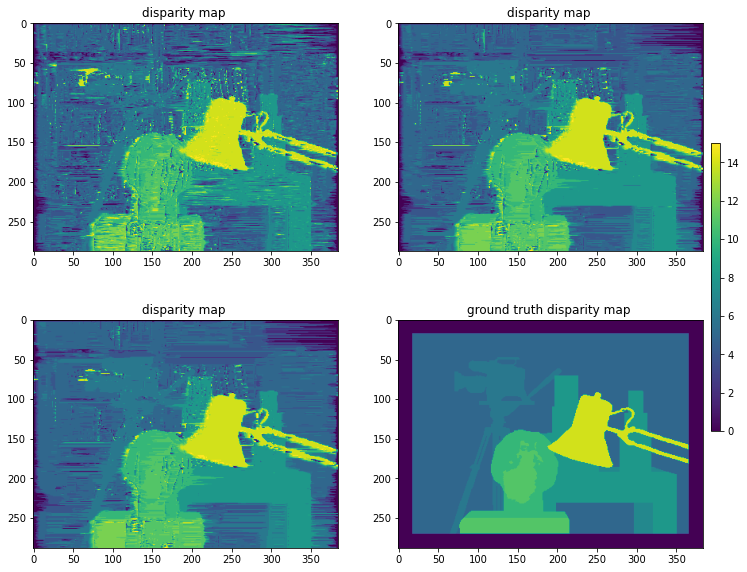

In [31]:
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("disparity map ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 5, 'SD', 'regular'), vmin = d_min, vmax = d_max)
plt.subplot(222)
plt.title("disparity map ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 20, 'SD', 'regular'), vmin = d_min, vmax = d_max)
plt.subplot(223)
plt.title("disparity map ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 40, 'SD', 'regular'), vmin = d_min, vmax = d_max)
plt.subplot(224)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Answer: Comparing the scanline-stereo with the window-based method,  the resulting image based on the scanline-stereo will contain more noises (straight lines shown above), since we are considering each scanline separately. Larger w value helps to reduce noise. But scanline-stereo is able to detect the object edges more accurately. Window-based method will prevent the noisy straight lines since we are considering pixel along with its neighborhood. But the edges of the object is not clearly detected, and the performance largely depends on the window size.  

### Problem 7(b): Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $\text{SD_array}(d)$ in Problem 7(a) by $$\text{SD_array}(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the better results. 
### NOTE 1: $h=1$ should be equivalent to Problem 7(a) above. 
### NOTE 2: this version combines window-based stereo with regularization along scan-lines. The case when $w=0$ should give the same results as in Problem 6(c).  

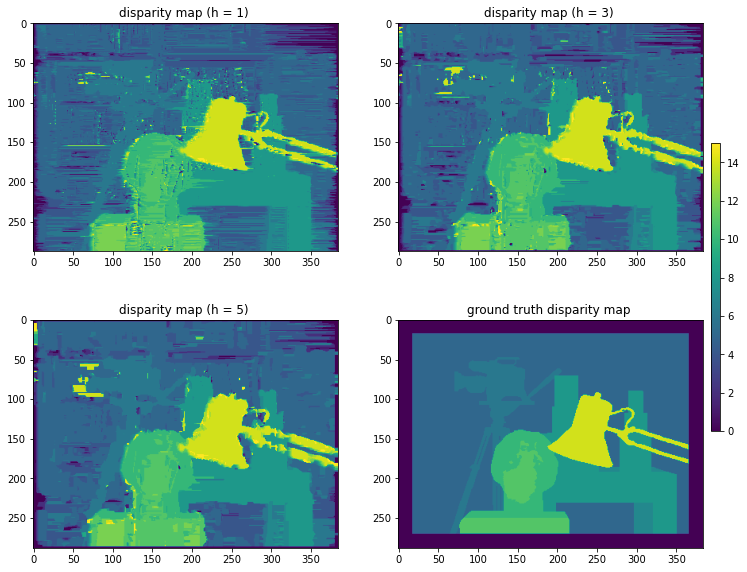

In [37]:
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("disparity map (h = 1) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 30, 'SSD', 'regular', h=1), vmin = d_min, vmax = d_max)
plt.subplot(222)
plt.title("disparity map (h = 3) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 50, 'SSD', 'regular', h=3), vmin = d_min, vmax = d_max)
plt.subplot(223)
plt.title("disparity map (h = 5) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 100, 'SSD', 'regular', h=5), vmin = d_min, vmax = d_max)
plt.subplot(224)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Answer: When h = 1, we get the standard scanline-stereo result. When h increases, by averaging SD in a small region, the scanline result becomes more similar to the window-based approach. With smaller h, we get more noisy lines, but the boundary of the objects is more accurate. With larger h, we get less noisy lines, but the boundary of the objects becomes more fuzzy. 

### Problem 8 [optional, small bonus]: test the performance for quadratic and (robust) truncated-quadratic regularization terms $$V_{pq}(d_p,d_q) = w|d_p-d_q|^2\;\;\;\text{and}\;\;\;\;V_{pq}(d_p,d_q) = min\{w|d_p-d_q|^2,T\}.$$ Discuss the results.

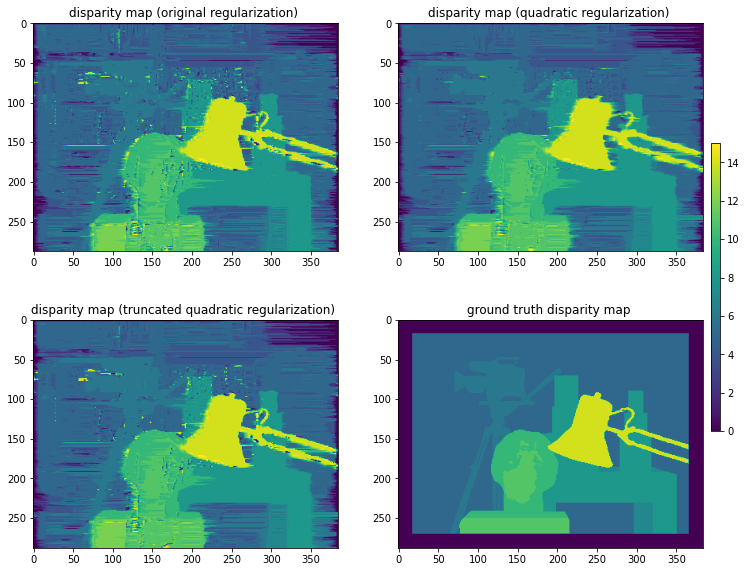

In [41]:
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("disparity map (original regularization) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 30, 'SD', 'regular'), vmin = d_min, vmax = d_max)
plt.subplot(222)
plt.title("disparity map (quadratic regularization) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 50, 'SD', 'quadratic'), vmin = d_min, vmax = d_max)
plt.subplot(223)
plt.title("disparity map (truncated quadratic regularization) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 50, 'SD', 'quadratic_truncate', T=400), vmin = d_min, vmax = d_max)
plt.subplot(224)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Answer: With the quadratic regularization term, the jump penalty increase more rapidly when the jump is larger. Thus, the algorithm would avoid jumping when there is a huge change in disparity levels. Therefore, we can see on the second image, the boundaries are not as accurate as the first image. (eg. the boundary of the lamp extends to left and right for some of the scanlines). With the truncated-quadratic, the jump penalty will still increase rapidly, but it will be at max equal to T. The object boundary is more accurate comparing to the quadratic method. Overall, using the quadratic regularization helps to reduce noise.

### Problem 9 [optional, small bonus]: test the case where regularization weight $w=w_{pq}$ depends on a specific pair of neighboring points. That is, $$V_{pq}(d_p,d_q) = w_{pq}|d_p-d_q|.$$ It is common to use local intensity contrast in the reference image to set such weights, for example $$w_{pq}=w\exp\frac{-\|I_p-I_q\|^2}{2\sigma^2}$$ which weighs the overall regularization constant $w$ by a Gaussian kernel (in RGB or grey-scale space). The latter makes it cheaper to draw large disparity jumps at "contrast edges" or "contrast boundaries" that are likely to happen at object boundaries. Note that bandwith parameter $\sigma$ is important - it controls sensitivity to contrast. Discuss the results.

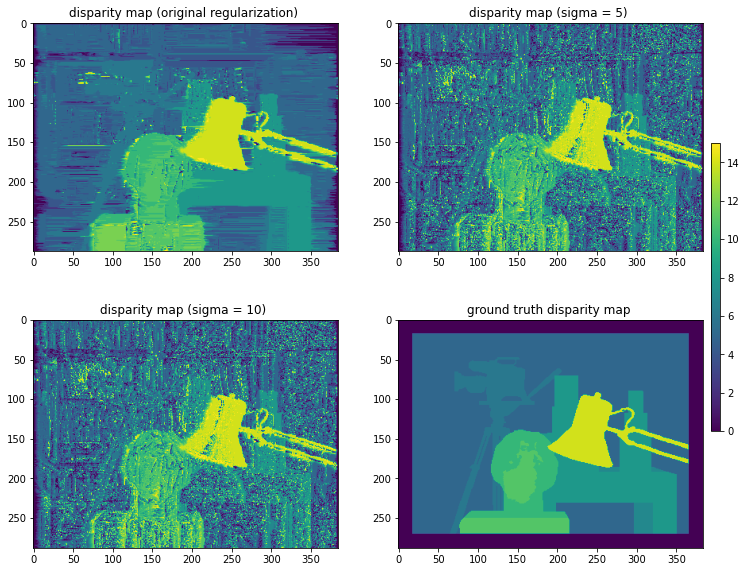

In [44]:
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("disparity map (original regularization) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 30, 'SD', 'regular'), vmin = d_min, vmax = d_max)
plt.subplot(222)
plt.title("disparity map (sigma = 5) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 20, 'SD', 'local_intensity', T=5), vmin = d_min, vmax = d_max)
plt.subplot(223)
plt.title("disparity map (sigma = 10) ")
plt.imshow(viterbi(im_left, im_right, d_min, d_max, 20, 'SD', 'local_intensity', T=10), vmin = d_min, vmax = d_max)
plt.subplot(224)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Answer: Using the local intensity contrast gives much more accurate object boundary, since the algorithm will more likely to jump between disparity levels at the object boundary. But it also introduce lots of noises at the same time.